<a href="https://colab.research.google.com/github/saharrrzz/AE-LSTM-architecture-/blob/master/paper_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from tensorflow import keras
import math
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Data**

In [57]:
df = read_csv('drive/MyDrive/House_Hold_dataset/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.replace('?', nan, inplace=True)
df = df.astype('float32')
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.429993,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.000000,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.820007,3.8,0.0,0.0,0.0


**filling missing data**

In [58]:
def fill_missing(values):
  one_day = 60 * 24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row, col]): 
      	values[row, col] = (values[row - one_day, col]) 

In [59]:
fill_missing(df.values)
df[df['Global_active_power'].isnull()]        

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,


**Daily data**

In [60]:
daily_groups = df.resample('D')
daily_data = daily_groups.sum()
daily_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-11-22,2041.536011,142.354004,345883.84375,8660.400391,4855.0,2110.0,10136.0
2010-11-23,1577.536011,137.449997,346428.75000,6731.200195,1871.0,458.0,7611.0
2010-11-24,1796.248047,132.460007,345644.59375,7559.399902,1096.0,2848.0,12224.0


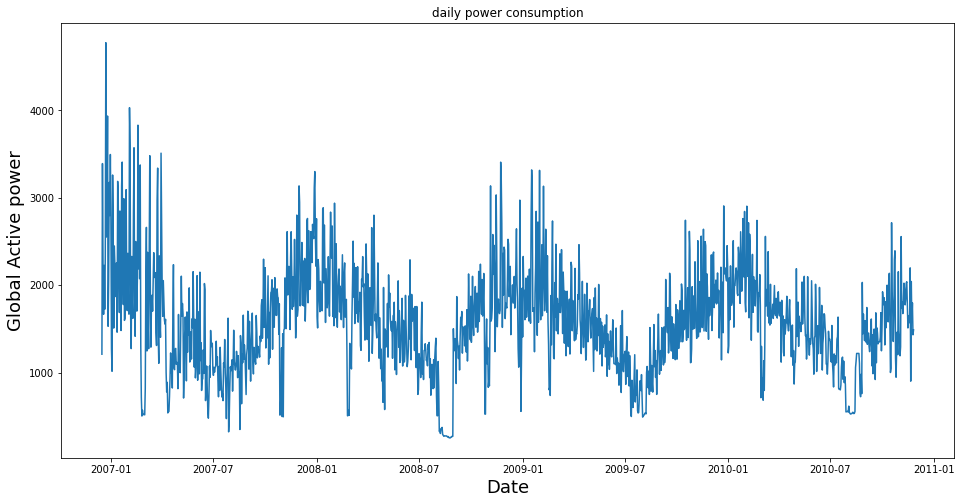

In [61]:
plt.figure(figsize=(16,8))
plt.title("daily power consumption")
plt.plot(daily_data['Global_active_power'])
plt.xlabel('Date',fontsize = 18 )
plt.ylabel('Global Active power',fontsize = 18 )
plt.show()

**Hourly Data**

In [62]:
Hourly_groups = df.resample('H')
Hourly_data = Hourly_groups.sum()
Hourly_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024002,8.243999,8447.179688,651.599976,0.0,19.0,607.0
2006-12-16 18:00:00,217.932007,4.802000,14074.809570,936.000000,0.0,403.0,1012.0
2006-12-16 19:00:00,204.013992,5.114000,13993.950195,870.200012,0.0,86.0,1001.0
2006-12-16 20:00:00,196.113998,4.506000,14044.290039,835.000000,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388000,4.600000,14229.519531,782.799988,0.0,25.0,1033.0
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,103.554001,3.684000,14224.179688,433.000000,0.0,0.0,772.0
2010-11-26 18:00:00,94.407997,3.222000,14251.910156,397.200012,0.0,0.0,0.0
2010-11-26 19:00:00,99.559998,3.602000,14204.459961,423.399994,0.0,4.0,0.0


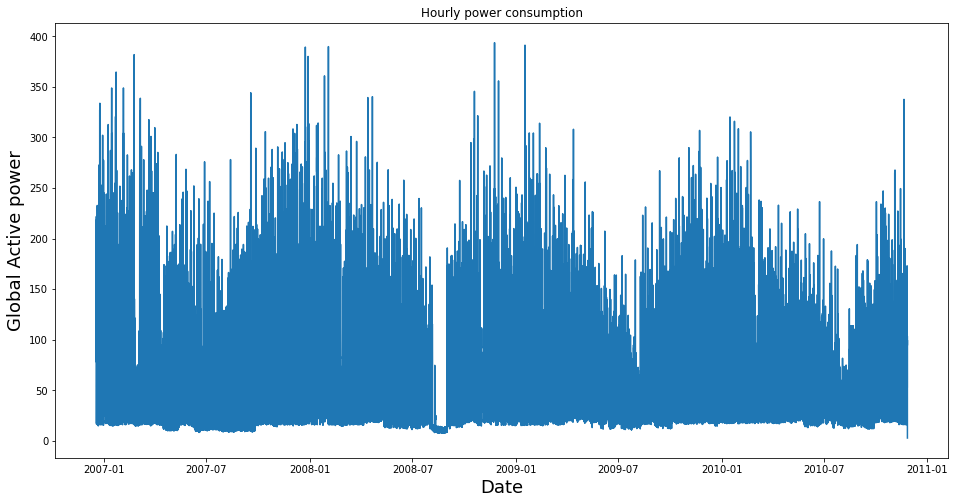

In [63]:
plt.figure(figsize=(16,8))
plt.title("Hourly power consumption")
plt.plot(Hourly_data['Global_active_power'])
plt.xlabel('Date',fontsize = 18 )
plt.ylabel('Global Active power',fontsize = 18 )
plt.show()

**Split data to test and train**

In [64]:
train_size = int(len(daily_data) * 0.80)
test_size = len(daily_data) - train_size
train, test = daily_data.iloc[0:train_size], daily_data.iloc[train_size:len(daily_data)]
print(len(train), len(test))

1153 289


In [ ]:
from sklearn.preprocessing import MinMaxScaler
f_columns = ['Global_reactive_power',	'Voltage',	'Global_intensity',	'Sub_metering_1',	'Sub_metering_2',	'Sub_metering_3']
f_transformer = MinMaxScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [ ]:
cnt_transformer = MinMaxScaler()
cnt_transformer = cnt_transformer.fit(train[['Global_active_power']])
train['Global_active_power'] = cnt_transformer.transform(train[['Global_active_power']])
test['Global_active_power'] = cnt_transformer.transform(test[['Global_active_power']])

**Create Dataset**

In [67]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),1:].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps:i + time_steps+1])
    return np.array(Xs), np.array(ys)

In [68]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Global_active_power, time_steps)
X_test, y_test = create_dataset(test, test.Global_active_power, time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1146, 7, 6) (1146, 1)
(282, 7, 6) (282, 1)


**Our Model**

In [69]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(7))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))

model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True)))
model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.25))
# model.add(Flatten())
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='relu'))
# opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer='adam')
model.build(input_shape=(None,X_train.shape[1],X_train.shape[2])) # `input_shape` is the shape of the input data                         # e.g. input_shape = (None, 32, 32, 3)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 7, 128)            69120     
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 7, 64)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 7, 64)             33024     
_________________________________________________________________
lstm_24 (LSTM)               (None, 7, 128)            98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 256)            263168    
_________________________________________________________________
lstm_26 (LSTM)               (None, 7, 64)            

In [70]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3)

Epoch 1/100
7/7 [==============================] - 10s 306ms/step - loss: 0.1044 - val_loss: 0.0673
Epoch 2/100
7/7 [==============================] - 1s 143ms/step - loss: 0.0677 - val_loss: 0.0175
Epoch 3/100
7/7 [==============================] - 1s 145ms/step - loss: 0.0293 - val_loss: 0.0124
Epoch 4/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0249 - val_loss: 0.0128
Epoch 5/100
7/7 [==============================] - 1s 143ms/step - loss: 0.0235 - val_loss: 0.0127
Epoch 6/100
7/7 [==============================] - 1s 141ms/step - loss: 0.0234 - val_loss: 0.0128
Epoch 7/100
7/7 [==============================] - 1s 143ms/step - loss: 0.0222 - val_loss: 0.0116
Epoch 8/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0214 - val_loss: 0.0111
Epoch 9/100
7/7 [==============================] - 1s 145ms/step - loss: 0.0206 - val_loss: 0.0103
Epoch 10/100
7/7 [==============================] - 1s 144ms/step - loss: 0.0195 - val_loss: 0.0078
Epoch 11

**Plot Validation**

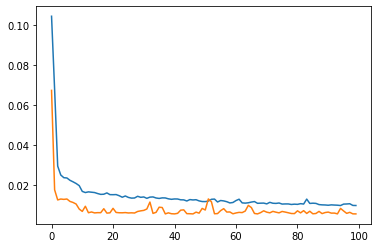

In [71]:
plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.show()

In [72]:
y_pred = model.predict(X_test)

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))

print(y_test_inv.shape)
print(y_pred_inv.shape)

testScore = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#MAPE=mean_absolute_percentage_error(y_true,y_pred)
MAE =mean_absolute_error(y_test_inv, y_pred_inv)

print('Test Score: %.2f RMSE' % (testScore))
#print('Test Score: %.2f MAPE' % (MAPE))
print('Test Score: %.2f MAE' % (MAE))

(1, 282)
(1, 282)
Test Score: 348.24 RMSE
Test Score: 249.35 MAE


**Plot Result**

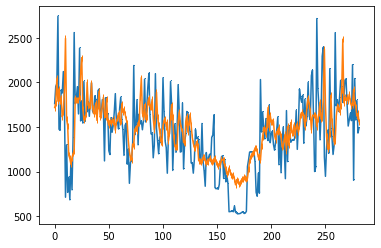

In [73]:
plt.plot(y_test_inv.flatten(), marker=',',label='true')
plt.plot(y_pred_inv.flatten(), marker='|',label='Predicted')
plt.show()